In [1]:
import ugradio
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import binned_statistic
import datetime

In [2]:
obs_time = datetime.datetime(2023, 2, 15, 14, 37)

In [16]:
def freq_to_period(freq):
    '''take frequency (in kHz)
    and converts to period (in microseconds)'''
    return (1/freq) * 1000

pwd = '../data/'
all_data = {}
for fins in ['on', 'off', 'cold', 'cal']:
    fname = f'{pwd}s_' + fins + '_3200.npy'
    all_data[fins] = np.load(fname)

freq_0 = 1420.4058e6 # Hz
num_samples = 2048 
samp_rate = 3.2e6 # Hz
c_speed = 299792458 # m/s

In [4]:
def fft(data, num_samp=2048, samp_rate=3.2e6):
    f = np.fft.fftshift(np.fft.fftfreq(num_samp, 1/samp_rate))
    Fx = np.fft.fftshift(np.fft.fft(data))
    return f, Fx

In [5]:
def avg_power(dname):
    data = all_data[dname]
    f, Fx = fft(data)
    pwr = np.abs(Fx)**2
    avg_pwr = np.mean(pwr, axis=0)
    return f, avg_pwr

In [6]:
def plot_avg_power(dname):
    data = all_data[dname]
    num_blocks = data.shape[0]
    num_samples = data.shape[1]
    time = np.arange(data.shape[1]) * freq_to_period(samp_rate/10**3) # in microseconds

    f, Fx = fft(data)
    pwr = np.abs(Fx)**2
    avg_pwr = np.mean(pwr, axis=0)

    # plot average power
    plt.figure()
    plt.plot(f, avg_pwr)
    plt.title('s_' + dname + ' Average Power Spectrum \n N = ' + str(num_blocks) + ' Blocks')
    plt.xlabel('Frequency')
    plt.ylabel('Average Power')
    plt.show()
# plot_avg_power()

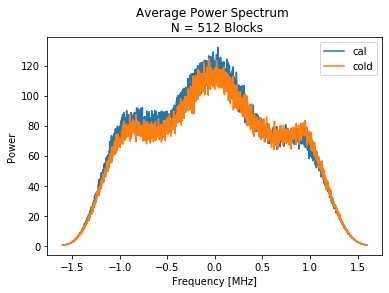

In [25]:
dname = 'cal'
data = all_data[dname]
num_blocks = data.shape[0]
num_samples = data.shape[1]
time = np.arange(data.shape[1]) * freq_to_period(samp_rate/10**3) # in microseconds

f, Fx = fft(data)
pwr = np.abs(Fx)**2
avg_pwr = np.mean(pwr, axis=0)

# plot average power
plt.figure()
plt.plot(f*10**-6, avg_pwr, label='cal')
plt.title('Average Power Spectrum \n N = ' + str(num_blocks) + ' Blocks')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power')

dname = 'cold'
data = all_data[dname]
num_blocks = data.shape[0]
num_samples = data.shape[1]
time = np.arange(data.shape[1]) * freq_to_period(samp_rate/10**3) # in microseconds

f, Fx = fft(data)
pwr = np.abs(Fx)**2
avg_pwr = np.mean(pwr, axis=0)

plt.plot(f*10**-6, avg_pwr, label='cold')
plt.legend()
plt.show()

In [24]:
def freq_resolution(samp_rate, num_samples):
    result = samp_rate / num_samples
    print('frequency resolution = ' + str(result) + ' [units of samp_rate]')
    return result

freq_resolution(samp_rate, 512*3)

frequency resolution = 2083.3333333333335 [units of samp_rate]


2083.3333333333335

In [9]:
def adjust_freq_res(freqs, data, bins):
    bin_means, bin_edges, binnumber = binned_statistic(freqs, data, bins=bins)
    return bin_edges[:-1], bin_means

In [10]:
import math

def get_julian_datetime(date):
    """
    Convert a datetime object into julian float.
    Args:
        date: datetime-object of date in question

    Returns: float - Julian calculated datetime.
    Raises: 
        TypeError : Incorrect parameter type
        ValueError: Date out of range of equation
    """

    # Ensure correct format
    if not isinstance(date, datetime.datetime):
        raise TypeError('Invalid type for parameter "date" - expecting datetime')
    elif date.year < 1801 or date.year > 2099:
        raise ValueError('Datetime must be between year 1801 and 2099')

    # Perform the calculation
    julian_datetime = 367 * date.year - int((7 * (date.year + int((date.month + 9) / 12.0))) / 4.0) + int(
        (275 * date.month) / 9.0) + date.day + 1721013.5 + (
                          date.hour + date.minute / 60.0 + date.second / math.pow(60,
                                                                                  2)) / 24.0 - 0.5 * math.copysign(
        1, 100 * date.year + date.month - 190002.5) + 0.5

    return julian_datetime

In [11]:
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, ICRS
from astropy.time import Time
from ugradio import nch

# RPI TIME IS WRONG

c = SkyCoord(frame="galactic", l=120*u.deg, b=0*u.deg)
lab = EarthLocation(lat=nch.lat*u.deg, lon=nch.lon*u.deg, height=nch.alt*u.m)
# obstime = Time(datetime.datetime.utcnow(), scale='utc', location=lab)
c.transform_to(ICRS())

<SkyCoord (ICRS): (ra, dec) in deg
    (6.45083114, 62.72572675)>

In [15]:
ugradio.doppler.get_projected_velocity(6.45, 62.72, get_julian_datetime(obs_time))

<Quantity -17589.20564131 m / s>

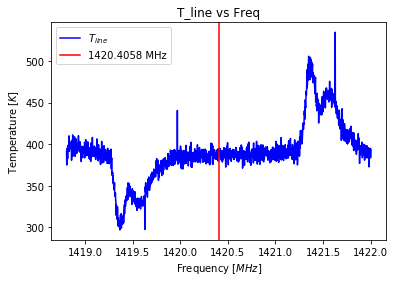

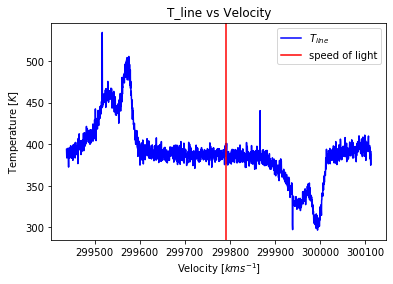

In [41]:
adj_data = {}
f_domain = []
adj_freq_res = num_samples/1.25
for fins in ['on', 'off', 'cold', 'cal']:
    data = all_data[fins]
    
    # average the power spectra of all blocks in data
    f, avg_pwr = avg_power(fins)
    
    # adjust frequency resolution to ~2 kHz
    if fins == 'cold' or fins == 'cal':
        adj_f, adj_pwr = f, avg_pwr
    else:
        adj_f, adj_pwr = adjust_freq_res(f, avg_pwr, adj_freq_res)
        f_domain = adj_f
    
    # save data
    adj_data[fins] = adj_pwr
    # f_domain = adj_f

s_on = adj_data['on']
s_off = adj_data['off']
s_cold = adj_data['cold']
s_cal = adj_data['cal']

# calc s_line
s_line = s_on / s_off

# calc G
T_syscal = 300
G = (T_syscal / np.sum(s_cal - s_cold)) * np.sum(s_cold) / 20

# calc T_line
T_line = np.multiply(s_line, G)

# freq to velocity domain conversion
v_domain = - (f_domain - freq_0) * c_speed / freq_0 - 17589.206 # m/s


plt.plot((f_domain + freq_0) * 10**-6, T_line, color='blue', label='$T_{line}$')
plt.axvline(freq_0 * 10**-6, color='r', label=str(freq_0*10**-6)+ ' MHz')
plt.title('T_line vs Freq')
plt.xlabel('Frequency [$MHz$]')
plt.ylabel('Temperature [$K$]')
plt.legend()
plt.show()

plt.plot(v_domain * 10**-3, T_line, color='blue', label='$T_{line}$')
plt.axvline(c_speed * 10**-3, color='r', label='speed of light')
plt.title('T_line vs Velocity')
plt.xlabel('Velocity [$km s^{-1}$]')
plt.ylabel('Temperature [$K$]')
plt.legend()
plt.show()

In [42]:
print(G)

392.5933615649237
